In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nib
from typing import Union, Sequence
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import h5py
from skimage.color import label2rgb
import json


In [66]:
class_test = torch.tensor([0,4,8,14])-1
bbox = torch.tensor([[100,40,30,-1],[100,20,10,5]])
print(torch.lt(bbox,0))
if any(torch.lt(bbox[0],0)):
    print("go")
if any(class_test >15):
    print('go')


tensor([[False, False, False,  True],
        [False, False, False, False]])
go


In [52]:
def convert_to_xyxy(box):  # box format: (xmin, ymin, w, h)
    x1, y1, w, h = box.T
    new_box = torch.stack((x1, y1, x1 + w, y1 + h), dim=1)
    # new_box = torch.stack((x1 + w / 2, y1 + h / 2, w, h), dim=1)
    return new_box  # new_box format: (xmin, ymin, xmax, ymax)


def cxcywh2xyxy(box): # box format: (cx, cy, w, h)
    cx, cy, w, h = box.T
    ws = w / 2
    hs = h / 2
    new_box = torch.stack((cx - ws, cy - hs, cx + ws, cy + hs), dim=1)
    return new_box


def xyxy2cxcywh(box): # box format: (x1, y1, x2, y2)fnms
    x1, y1, x2, y2 = box.T
    new_box = torch.stack(((x1 + x2) / 2, (y1 + y2) / 2, x2 - x1, y2 - y1), dim=1)
    return new_box


target = dict({"bbox":torch.tensor([[120.,150.,20.,30.]])})
box_in = convert_to_xyxy(target["bbox"])
box_loss = xyxy2cxcywh(box_in)
box_out = cxcywh2xyxy(box_loss)
print(box_out)

tensor([[120., 150., 140., 180.]])


In [43]:
import torch
from collections import OrderedDict
device = torch.device('cuda')
ckpt = torch.load("/home/tmpaquaij/Downloads/yolov5s_official_2cf45318.pth",map_location=device)
print(type(ckpt))
ckpt_1 = OrderedDict({".".join(name.split('.')[1:]):value for name, value in ckpt.items() if name.startswith('backbone')})
print(ckpt_1)

<class 'collections.OrderedDict'>
OrderedDict([('body.layer0.conv.conv.weight', tensor([[[[ 0.0030, -0.0234,  0.0133],
          [-0.0119,  0.1242,  0.1123],
          [ 0.0251, -0.0195, -0.0286]],

         [[ 0.0108, -0.0304, -0.0049],
          [-0.0053,  0.1558,  0.1373],
          [-0.0050, -0.0386, -0.0454]],

         [[ 0.0180, -0.0166,  0.0159],
          [-0.0088,  0.0862,  0.0728],
          [ 0.0166, -0.0161, -0.0163]],

         ...,

         [[-0.0108,  0.0582, -0.0165],
          [-0.0406, -0.1556, -0.0724],
          [ 0.0142,  0.0030,  0.0130]],

         [[-0.0046,  0.0791, -0.0203],
          [-0.0349, -0.1217, -0.0662],
          [-0.0059, -0.0007, -0.0176]],

         [[-0.0135,  0.0170, -0.0209],
          [-0.0320, -0.1250, -0.0555],
          [ 0.0073,  0.0346,  0.0079]]],


        [[[-0.0070, -0.0141, -0.0396],
          [-0.0385, -0.0435, -0.1082],
          [-0.0536, -0.0784, -0.1222]],

         [[ 0.0417, -0.0269, -0.0085],
          [ 0.0477,  0.2754,  0

In [14]:
a = np.array([224/512,256/512])
anchors = [
            [[10, 13]*a, [16, 30]*a, [33, 23]*a],
            [[30, 61]*a, [62, 45]*a, [59, 119]*a],
            [[116, 90]*a, [156, 198]*a, [373, 326]*a]
        ]
print(anchors)

[[array([4.375, 6.5  ]), array([ 7., 15.]), array([14.4375, 11.5   ])], [array([13.125, 30.5  ]), array([27.125, 22.5  ]), array([25.8125, 59.5   ])], [array([50.75, 45.  ]), array([68.25, 99.  ]), array([163.1875, 163.    ])]]


In [3]:
# Function for plotting MRI scans


def get_scaled_image(
        x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
    """Scales image by intensity percentile (and optionally clips to [0, 1]).

    Args:
      x (torch.Tensor | np.ndarray): The image to process.
      percentile (float): The percentile of magnitude to scale by.
      clip (bool): If True, clip values between [0, 1]

    Returns:
      torch.Tensor | np.ndarray: The scaled image.
    """
    is_numpy = isinstance(x, np.ndarray)
    if is_numpy:
        x = torch.as_tensor(x)

    scale_factor = torch.quantile(x, percentile)
    x = x / scale_factor
    if clip:
        x = torch.clip(x, 0, 1)

    if is_numpy:
        x = x.numpy()

    return x


def plot_images(
        images, processor=None, disable_ticks=True, titles: Sequence[str] = None,
        ylabel: str = None, xlabels: Sequence[str] = None, cmap: str = "gray",
        show_cbar: bool = False, overlay=None, opacity: float = 0.3,
        hsize=5, wsize=5, axs=None, fontsize=20
):
    """Plot multiple images in a single row.

    Add an overlay with the `overlay=` argument.
    Add a colorbar with `show_cbar=True`.
    """

    def get_default_values(x, default=""):
        if x is None:
            return [default] * len(images)
        return x

    titles = get_default_values(titles)
    ylabels = get_default_values(images)
    xlabels = get_default_values(xlabels)

    N = len(images)
    if axs is None:
        fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
    else:
        assert len(axs) >= N
        fig = axs.flatten()[0].get_figure()
    k = 0
    for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
        if processor is not None:
            img = processor(img)
        if type(cmap) == list:
            im = ax.imshow(img, cmap=cmap[k])
            if type(show_cbar) == list:
                if show_cbar[k]:
                    fig.subplots_adjust(right=0.8)
                    cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.60])
                    fig.colorbar(im, cax=cbar_ax)
        else:
            im = ax.imshow(img, cmap=cmap)
        k = k + 1
        ax.set_title(title, fontsize=fontsize)
        ax.set_xlabel(xlabel)

    if type(overlay) == list:
        for i, ax in enumerate(axs.flatten()):
            if overlay[i] is not None:
                im = ax.imshow(overlay[i], alpha=opacity)

    if disable_ticks:
        for ax in axs.flatten():
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

    return axs


# Function for transforming segmentation classes into one hot
def categorical_to_one_hot(x, channel_dim: int = 1, background=0, num_categories=None, dtype=None):
    """Converts categorical predictions to one-hot encoded predictions.

    Args:
        x (torch.Tensor | np.ndarray): Categorical array or tensor.
        channel_dim (int, optional): Channel dimension for output tensor.
        background (int | NoneType, optional): The numerical label of the
            background category. If ``None``, assumes that the background is
            a class that should be one-hot encoded.
        num_categories (int, optional): Number of categories (excluding background).
            Defaults to the ``max(x) + 1``.
        dtype (type, optional): Data type of the output.
            Defaults to boolean (``torch.bool`` or ``np.bool``).

    Returns:
        torch.Tensor | np.ndarray: One-hot encoded predictions.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.from_numpy(x)

    if num_categories is None:
        num_categories = torch.max(x).type(torch.long).cpu().item()
    num_categories += 1

    shape = x.shape
    out_shape = (num_categories,) + shape

    if dtype is None:
        dtype = torch.bool
    default_value = True if dtype == torch.bool else 1
    if x.dtype != torch.long:
        x = x.type(torch.long)

    out = torch.zeros(out_shape, dtype=dtype, device=x.device)
    out.scatter_(0, x.reshape((1,) + x.shape), default_value)
    if background is not None:
        out = torch.cat([out[0:background], out[background + 1:]], dim=0)
    if channel_dim != 0:
        if channel_dim < 0:
            channel_dim = out.ndim + channel_dim
        order = (channel_dim,) + tuple(d for d in range(out.ndim) if d != channel_dim)
        out = out.permute(tuple(np.argsort(order)))
        out = out.contiguous()

    if is_ndarray:
        out = out.numpy()
    return out


# Function for combining one hot encoded classes
def collect_mask(
        mask: np.ndarray,
        index: Sequence[Union[int, Sequence[int], int]],
        out_channel_first: bool = True,
):
    """Collect masks by index.

    Collated indices will be summed. For example, `index=(1,(3,4))` will return
    `np.stack(mask[...,1], mask[...,3]+mask[...,4])`.

    TODO: Add support for adding background.

    Args:
        mask (ndarray): A (...)xC array.
        index (Sequence[int]): The index/indices to select in mask.
            If sub-indices are collated, they will be summed.
        out_channel_first (bool, optional): Reorders dimensions of output mask to Cx(...)
    """
    if isinstance(index, int):
        index = (index,)

    if not any(isinstance(idx, Sequence) for idx in index):
        mask = mask[..., index]
    else:
        o_seg = []
        for idx in index:
            c_seg = mask[..., idx]
            if isinstance(idx, Sequence):
                c_seg = np.sum(c_seg, axis=-1)
            o_seg.append(c_seg)
        mask = np.stack(o_seg, axis=-1)

    if out_channel_first:
        last_idx = len(mask.shape) - 1
        mask = np.transpose(mask, (last_idx,) + tuple(range(0, last_idx)))

    return mask


# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out

In [4]:
# Load the corresponding data
dataset_dir = '/data/projects/recon/data/public/multitask/skm-tea/v1-release/'
meta_dir = Path(dataset_dir) / 'all_metadata.csv'
meta_data = pd.read_csv(meta_dir)

recon_file = Path(dataset_dir) / "files_recon_calib-24/"

seg_file = Path(dataset_dir)  / str("segmentation_masks/raw-data-track/")

file = json("")
patient_id = 'MTR_013' #meta_data['MTR_ID'][60]
print(patient_id)
meta_data = meta_data[meta_data['MTR_ID']==patient_id]

with h5py.File(str(recon_file / patient_id)+'.h5', "r") as f:
    print(f.keys())
    kspace_org = f["kspace"][:, :, :, :, :]  # Shape: (x, ky, kz, #echos, #coils)
    maps_org = f["maps"][:, :, :, :, :]      # Shape: (x, ky, kz, #coils, #maps) - maps are the same for both echos
    image_org = f['target'][()]

segmentation = nib.load(str(seg_file / patient_id)+'.nii.gz').get_fdata()
segmentation_one = categorical_to_one_hot(segmentation,channel_dim=-1)
segmentation_one_org = collect_mask(segmentation_one, (0, 1, (2, 3), (4, 5)), out_channel_first=False)
crop_scale = [1,1,1] #Option to crop
print(kspace_org.shape, segmentation_one_org.shape, maps_org.shape)

MTR_013
<KeysViewHDF5 ['kspace', 'maps', 'masks', 'target']>
(512, 512, 160, 2, 8) (512, 512, 160, 4) (512, 512, 160, 8, 1)


dict_keys(['info', 'categories', 'tissues', 'images', 'annotations'])
[{'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 1, 'name': 'Meniscal Tear (Myxoid)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 2, 'name': 'Meniscal Tear (Horizontal)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 3, 'name': 'Meniscal Tear (Radial)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 4, 'name': 'Meniscal Tear (Vertical/Longitudinal)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 5, 'name': 'Meniscal Tear (Oblique)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 6, 'name': 'Meniscal Tear (Complex)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 7, 'name': 'Meniscal Tear (Flap)'}, {'supercategory': 'Meniscal Tear', 'supercategory_id': 1, 'id': 8, 'name': 'Meniscal Tear (Extrusion)'}, {'supercategory': 'Ligament Tear', 'supercategory_id': 2, 'id': 9, 'name': 'Ligament Tear (

In [134]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
with h5py.File('/data/projects/recon/data/public/multitask/skm-tea/v1-release/files_recon_calib-24/MTR_026.h5', "r") as f:
    target_org = f["target"][:, :, :, :, :]  # Shape: (x, ky, kz, #echos, #coils)


annotation_set_org ="/data/projects/recon/data/public/multitask/skm-tea/v1-release/annotations/v1.0.0/test.json"
dataslices = [50]
with open(annotation_set_org, "r", encoding="utf-8") as f:
    annotations = json.load(f)
bbox_classes =[]
for image in annotations["images"]:

    if image['file_name'] == "MTR_026.h5":

        annotations = [annotation for annotation in annotations['annotations'] if annotation['image_id'] == image['id']]
        orientation = image['orientation']
        shape = image['matrix_shape']
        for dataslice in dataslices:
            bboxes = []
            categories = []
            tissues = []

            for annotation in annotations:
                if dataslice in range(int(annotation['bbox'][2]),int(annotation['bbox'][2] + annotation['bbox'][5]), 1) and annotation["id"]!=29:
                    print(annotation['bbox'])
                    bboxes.append([annotation['bbox'][0],annotation['bbox'][1],annotation['bbox'][3],annotation['bbox'][4]])
                    categories.append(annotation['category_id'])
                    tissues.append(annotation['tissue_id'])
            bbox_classes.append(dict(slice_id=np.array([dataslice]), boxes=np.array(bboxes),labels=np.array(categories),tissues=np.array(tissues)))





print(bbox_classes)
print(orientation)


[]
['SI', 'AP', 'LR']


IndexError: list index out of range

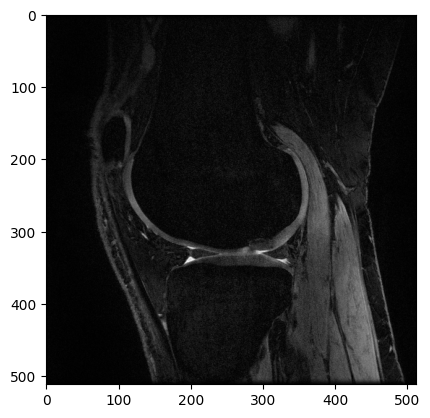

In [135]:
fig, ax = plt.subplots()
ax.imshow(np.abs(target_org[:,:,50,0]+target_org[:,:,50,1]),cmap='gray')

x=bbox_classes[0]["boxes"][0][0]
y=bbox_classes[0]["boxes"][0][1]
width = bbox_classes[0]["boxes"][0][2]
height = bbox_classes[0]["boxes"][0][3]

rect = patch.Rectangle((y,x),height,width, linewidth=1,edgecolor='r',facecolor=None,alpha=0.2)
ax.add_patch(rect)


In [136]:
with open(annotation_set_org, "r", encoding="utf-8") as f:
    annotations = json.load(f)
bbox_classes =[]
for image in annotations["images"]:
    print(image["orientation"])

['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'RL']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'RL']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'RL']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'RL']
['SI', 'AP', 'LR']
['SI', 'AP', 'RL']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'LR']
['SI', 'AP', 'RL']
['SI', 'AP', 'LR']


In [24]:
model = torch.hub.load('ultralytics/yolov5', 'custom',path = 'yolov5s.pt')
print(np.abs(image_org[128:-128,125:-125,80,0,0]).shape)
pred = model(np.abs(image_org[128:-128,125:-125,80,0,0]))
pred.pandas().xyxy[0]

Using cache found in /home/tmpaquaij/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-1-22 Python-3.10.13 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


(256, 262)


,xmin,ymin,xmax,ymax,confidence,class,name
0,11.462501,1.912500,11.462501,1.912500,1.0,9,traffic light
1,14.736087,1.912500,14.736503,1.912500,1.0,32,sports ball
2,21.287500,1.912500,21.287500,1.912500,1.0,9,traffic light
3,19.768314,1.912500,35.906689,1.912500,1.0,32,sports ball
4,55.675095,1.912500,72.049911,1.912500,1.0,74,clock
...,...,...,...,...,...,...,...
995,81.875000,13.375001,81.875000,13.375001,1.0,60,dining table
996,63.876850,13.375001,112.972939,13.375001,1.0,60,dining table
997,70.412498,0.000000,119.537506,51.119919,1.0,60,dining table
998,76.962502,13.066896,126.087502,13.683105,1.0,57,couch


In [7]:
print(model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     